Generating new MNIST digits with VAE

How to use VAE(Variational Auto-Encoder) to generate different MNIST images? VAE use convolution layers in encoder and decoder.

In [2]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


Step 1: Load and explore the dataset

11490434/11490434 [==============================] - 1s 0us/step
y_train[20] =  4
y_train[500] =  3
y_train[3000] =  9
y_train[9000] =  6


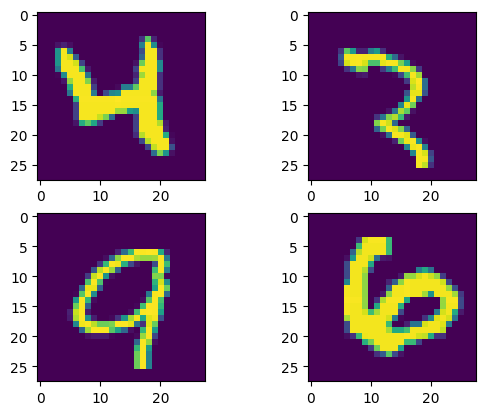

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
# Only get some data to train and test
train_len = 10000
test_len = 1000
x_train = np.reshape(x_train[:train_len], [-1, image_size, image_size, 1])
x_test = np.reshape(x_test[:test_len], [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_test = y_test[:test_len]
x_train.shape
(10000, 28, 28, 1)
x_test.shape
(1000, 28, 28, 1)
#Show MNIST images
x_train_show = x_train.reshape(-1,28,28)
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train_show[20])
print('y_train[20] = ', y_train[20])
plt.subplot(222)
plt.imshow(x_train_show[500])
print('y_train[500] = ', y_train[500])
plt.subplot(223)
plt.imshow(x_train_show[3000])
print('y_train[3000] = ', y_train[3000])
plt.subplot(224)
plt.imshow(x_train_show[9000])
print('y_train[9000] = ', y_train[9000])
plt.show()
y_train[20] =  4
y_train[500] =  3
y_train[3000] =  9
y_train[9000] =  6

Step 2: Prepare functions to produce and plot the results (before we start)

In [7]:
# reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,1)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def plot_results(encoder, decoder, x_test, y_test, batch_size=128):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)

    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

Step 3: Set up network parameters

In [8]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30
use_mse = True
load_weights = False

Step 4: Build encoder model

In [10]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

Step 5: Build decoder model

In [12]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289 

Step 6: Build VAE model = encoder + decoder

In [23]:
# VAE Model
vae_outputs = decoder(encoder(inputs)[2])  # Use the z tensor from the encoder
vae = Model(inputs, vae_outputs, name='vae')

Loss = reconstruction loss + KL loss

In [24]:
# Loss Calculation
if use_mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(vae_outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(vae_outputs))
    reconstruction_loss *= image_size * image_size

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


Compile model

In [25]:
# Compile the VAE model
vae.compile(optimizer='rmsprop')
vae.summary()
Model: "vae"

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  69076     ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 28, 28, 1)            65089     ['encoder[4][2]']             
                                                                                                

Step 7: Fit model

In [27]:
if load_weights:
    vae = vae.load_weights(args.weights)
else:
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('vae_cnn_mnist.h5')


Epoch 1/30
313/313 [==============================] - 14s 8ms/step - loss: 0.0877 - val_loss: 0.0660
Epoch 2/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0678 - val_loss: 0.0654
Epoch 3/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0676 - val_loss: 0.0656
Epoch 4/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0676 - val_loss: 0.0656
Epoch 5/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0675 - val_loss: 0.0656
Epoch 6/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0675 - val_loss: 0.0654
Epoch 7/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0675 - val_loss: 0.0653
Epoch 8/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0674 - val_loss: 0.0655
Epoch 9/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0674 - val_loss: 0.0653
Epoch 10/30
313/313 [==============================] - 2s 6ms/step - loss: 0.0674 - val_loss: 0.065

Step 8: Plot new MNIST images

32/32 [==============================] - 0s 2ms/step


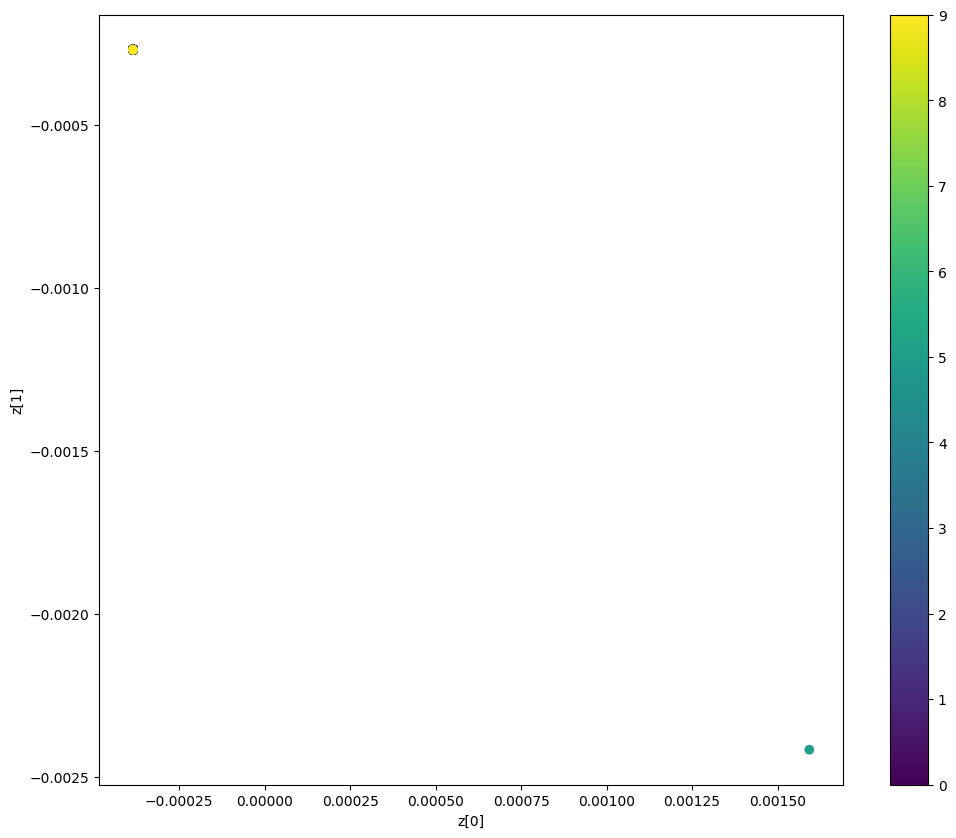

1/1 [==============================] - 0s 20ms/step


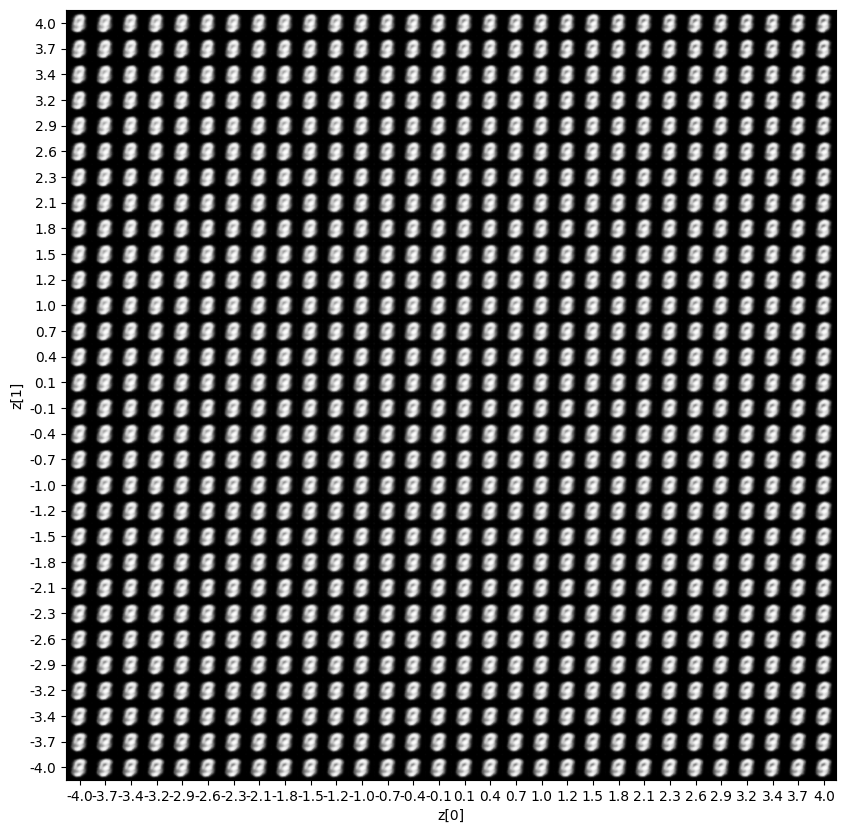

In [28]:
plot_results(encoder, decoder, x_test, y_test, batch_size=batch_size)